# This notebook was prepared by the team: Aysel Mirzoeva and Borisiuk Anna


# Homework: Galaxy Image Classification

**Course:** Deep Learning for Computer Vision

**Objective:** Train a deep learning model to classify galaxy images from the Galaxy10 DECals dataset into one of 10 categories.

**Dataset:** Galaxy10 DECals
* **Source:** [Hugging Face Datasets](https://huggingface.co/datasets/matthieulel/galaxy10_decals)
* **Description:** Contains 17,736 color galaxy images (256x256 pixels) divided into 10 classes. Images originate from DESI Legacy Imaging Surveys, with labels from Galaxy Zoo.
* **Classes:**
    * 0: Disturbed Galaxies
    * 1: Merging Galaxies
    * 2: Round Smooth Galaxies
    * 3: In-between Round Smooth Galaxies
    * 4: Cigar Shaped Smooth Galaxies
    * 5: Barred Spiral Galaxies
    * 6: Unbarred Tight Spiral Galaxies
    * 7: Unbarred Loose Spiral Galaxies
    * 8: Edge-on Galaxies without Bulge
    * 9: Edge-on Galaxies with Bulge

**Tasks:**
1.  Load and explore the dataset.
2.  Preprocess the images.
3.  Define and train a model.
4.  Evaluate the model's performance using standard classification metrics on the test set.

Homework is succesfully completed if you get >0.9 Accuracy on the Test set.

# Prerequisites

In [ ]:
!pip install datasets scikit-learn matplotlib numpy -q >> None

import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.


In [ ]:
!pip install wandb -q

import torch
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as T
import torchvision.models as models
import torchvision.transforms.functional as TF
from PIL import Image
from tqdm import tqdm
from datasets import load_dataset
import wandb

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)

In [ ]:
# Cell 4: Visualize one example from each class
def show_class_examples(dataset, class_names_map, samples_per_row=5, num_rows=2):
    """Displays one sample image for each class."""
    if not dataset:
        print("Dataset not loaded. Cannot visualize.")
        return

    num_classes_to_show = len(class_names_map)
    if num_classes_to_show > samples_per_row * num_rows:
        print(f"Warning: Not enough space to show all {num_classes_to_show} classes.")
        num_classes_to_show = samples_per_row * num_rows

    fig, axes = plt.subplots(num_rows, samples_per_row, figsize=(15, 6)) # Adjusted figsize
    axes = axes.ravel() # Flatten the axes array

    split_name = 'train' if 'train' in dataset else list(dataset.keys())[0]
    data_split = dataset[split_name]

    images_shown = 0
    processed_labels = set()

    for i in range(len(data_split)):
        if images_shown >= num_classes_to_show:
            break # Stop once we have shown one for each target class

        example = data_split[i]
        label = example['label']

        if label not in processed_labels and label < num_classes_to_show:
            img = example['image']
            ax_idx = label # Use label directly as index into the flattened axes
            axes[ax_idx].imshow(img)
            axes[ax_idx].set_title(f"Class {label}: {class_names_map[label]}", fontsize=9)
            axes[ax_idx].axis('off')
            processed_labels.add(label)
            images_shown += 1

    # Hide any unused subplots
    for i in range(images_shown, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def evaluate_predictions(predicted_labels, true_labels, class_names_list):
    """
    Calculates and prints classification metrics from predicted labels and true labels.

    Args:
        predicted_labels (list or np.array): The predicted class indices for the test set.
        true_labels (list or np.array): The ground truth class indices for the test set.
        class_names_list (list): A list of strings containing the names of the classes.
    """
    if len(predicted_labels) != len(true_labels):
        print(f"Error: Number of predictions ({len(predicted_labels)}) does not match number of true labels ({len(true_labels)}).")
        return None # Indicate failure

    print(f"Evaluating {len(predicted_labels)} predictions against true labels...")

    # Ensure inputs are numpy arrays for scikit-learn
    predicted_labels = np.array(predicted_labels)
    true_labels = np.array(true_labels)

    # Calculate metrics using scikit-learn
    accuracy = accuracy_score(true_labels, predicted_labels)
    # Calculate precision, recall, f1 per class and average (weighted)
    # Use zero_division=0 to handle cases where a class might not be predicted or present in labels
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='weighted', zero_division=0
    )
    # Get per-class metrics as well
    per_class_precision, per_class_recall, per_class_f1, per_class_support = precision_recall_fscore_support(
        true_labels, predicted_labels, average=None, zero_division=0, labels=range(len(class_names_list))
    )

    # Generate Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=range(len(class_names_list)))

    # Print Metrics
    print(f"\n--- Evaluation Metrics ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Weighted Precision: {precision:.4f}")
    print(f"Weighted Recall: {recall:.4f}")
    print(f"Weighted F1-Score: {f1:.4f}")
    print("-" * 25)
    print("Per-Class Metrics:")
    print(f"{'Class':<30} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10} | {'Support':<10}")
    print("-" * 80)
    for i, name in enumerate(class_names_list):
         # Handle cases where support might be 0 for a class in true labels if dataset is small/filtered
         support = per_class_support[i] if i < len(per_class_support) else 0
         prec = per_class_precision[i] if i < len(per_class_precision) else 0
         rec = per_class_recall[i] if i < len(per_class_recall) else 0
         f1s = per_class_f1[i] if i < len(per_class_f1) else 0
         print(f"{f'{i}: {name}':<30} | {prec:<10.4f} | {rec:<10.4f} | {f1s:<10.4f} | {support:<10}")
    print("-" * 80)

    # Plot Confusion Matrix
    print("\nPlotting Confusion Matrix...")
    fig, ax = plt.subplots(figsize=(10, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_list)
    disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

    metrics = {
        'accuracy': accuracy,
        'precision_weighted': precision,
        'recall_weighted': recall,
        'f1_weighted': f1,
        'confusion_matrix': cm,
        'per_class_metrics': {
            'precision': per_class_precision,
            'recall': per_class_recall,
            'f1': per_class_f1,
            'support': per_class_support
        }
    }
    return metrics

# Data

In [ ]:
dataset_name = "matthieulel/galaxy10_decals"
galaxy_dataset = datasets.load_dataset(dataset_name)

# Define class names based on the dataset card
class_names = [
    "Disturbed", "Merging", "Round Smooth", "In-between Round Smooth",
    "Cigar Shaped Smooth", "Barred Spiral", "Unbarred Tight Spiral",
    "Unbarred Loose Spiral", "Edge-on without Bulge", "Edge-on with Bulge"
]

# Create a dictionary for easy lookup
label2name = {i: name for i, name in enumerate(class_names)}
name2label = {name: i for i, name in enumerate(class_names)}

num_classes = len(class_names)
print(f"\nNumber of classes: {num_classes}")
print("Class names:", class_names)

In [ ]:
show_class_examples(galaxy_dataset, label2name, samples_per_row=5, num_rows=2)

# Training

## EfficientNet-B0

Below are graphs of efficent_net with different hyperparameters

As it can be seen, during training all variations of parameters, the loss fell steadily and did not diverge, but the model was retrained as in the previous jupyter. We used the same techniques described in part 1, we just did more experiments on efficent net, and we managed to beat the quality of 87 and 88! Wandb will be attached to the repository

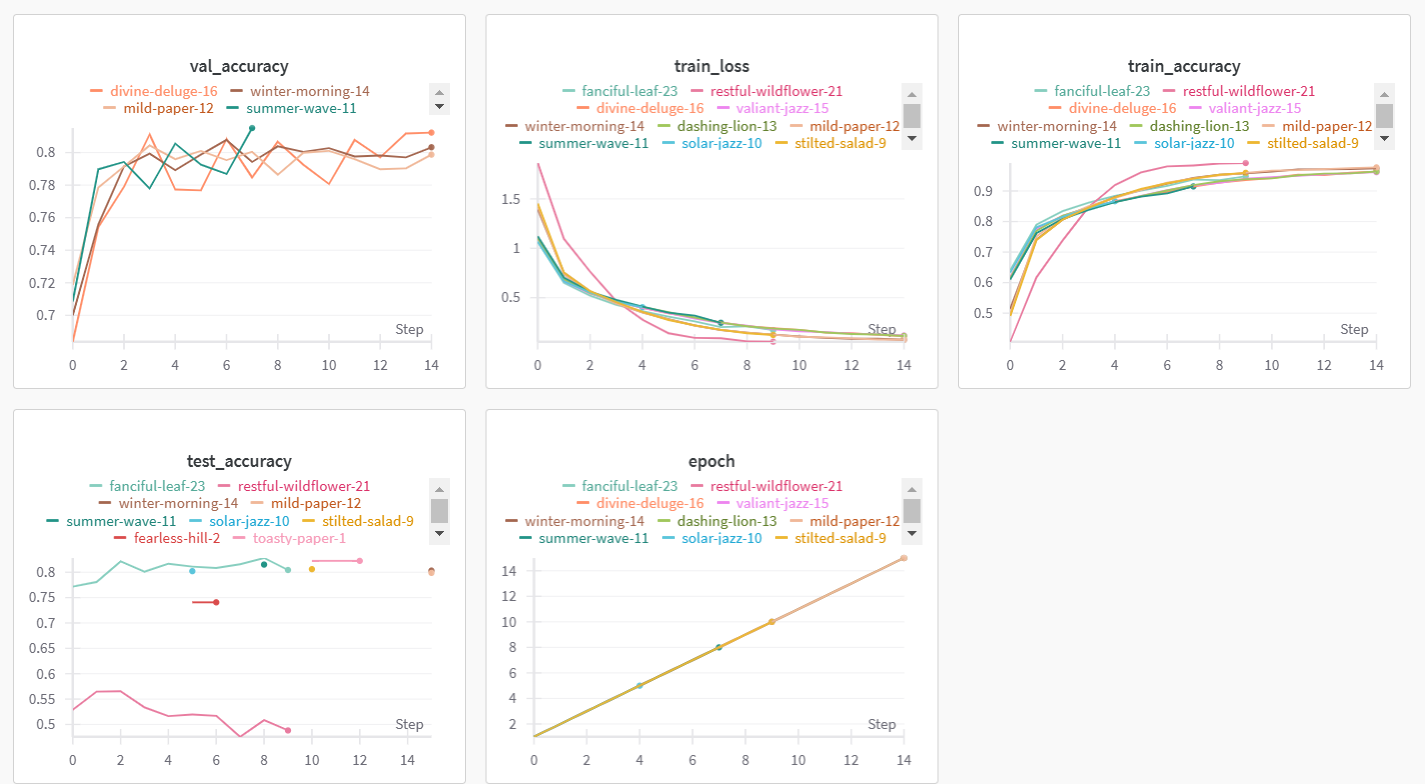

We compared training on normalization from dataset and imagenet - but it didn't give much gain, on imagenet it seemed to work even better

In [ ]:
# Were obtained by calculating the mean and variance on this dataset.
mean = torch.tensor([0.1675, 0.1626, 0.1589])
std = torch.tensor([0.1288, 0.1181, 0.1116])

# ImageNet
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [ ]:
SEED = 42
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
LR_MAX = 1e-3
WEIGHT_DECAY = 1e-4
TRAIN_VAL_SPLIT = 0.1
ALPHA_MIXUP = 0.4
SMOOTHING = 0.1

In [ ]:
train_tf = T.Compose([
    T.RandomRotation(10),
    T.ColorJitter(0.3,0.3,0.3),
    T.ToTensor(),
    T.Normalize(mean, std),
])
val_tf = T.Compose([
    T.Resize((IMG_SIZE,IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean, std),
])

class GalaxyDataset(Dataset):
    def __init__(self, hf_ds, transform):
        self.ds = hf_ds
        self.tf = transform
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, i):
        ex = self.ds[i]
        img = ex["image"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        img = self.tf(img)
        return img, ex["label"]

# Split train→train/val, subload test
from datasets import load_dataset
dataset = load_dataset("matthieulel/galaxy10_decals")
split = dataset["train"].train_test_split(test_size=TRAIN_VAL_SPLIT, seed=SEED)
train_ds = split["train"]
val_ds   = split["test"]
test_ds  = dataset["test"]

train_loader = DataLoader(GalaxyDataset(train_ds, train_tf),
                          batch_size=BATCH_SIZE, shuffle=True,  num_workers=4)
val_loader   = DataLoader(GalaxyDataset(val_ds,   val_tf),
                          batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

model = models.efficientnet_b0(pretrained=True)
for p in model.features.parameters():
    p.requires_grad = False

nf = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(nf, 10)
)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_val, epochs_no = 0.0, 0
for epoch in range(1, EPOCHS+1):
    model.train()
    acc_train = 0
    for imgs, lbls in tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}"):
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()
        acc_train += (out.argmax(1)==lbls).sum().item()
    acc_train /= len(train_loader.dataset)

    if epoch == 2:
        for p in model.features.parameters():
            p.requires_grad = True

    model.eval()
    acc_val = 0
    with torch.no_grad():
        for imgs, lbls in val_loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            acc_val += (model(imgs).argmax(1)==lbls).sum().item()
    acc_val /= len(val_loader.dataset)

    scheduler.step()
    print(f"Epoch {epoch}: train_acc={acc_train:.4f}, val_acc={acc_val:.4f}")

    if acc_val > best_val:
        best_val = acc_val
        epochs_no = 0
        torch.save(model.state_dict(), "best.pth")
    else:
        epochs_no += 1
        if epochs_no >= PATIENCE:
            print("Early stopping")
            break


## EfficientNet_B3

In [ ]:
train_tf = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.7,1.0)),
    T.RandAugment(num_ops=2, magnitude=10),
    T.ColorJitter(0.4,0.4,0.4,0.1),
    T.ToTensor(),
    T.Normalize(mean,std),
])
val_tf = T.Compose([
    T.Resize((IMG_SIZE,IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean,std)
])

class GalaxyDataset(Dataset):
    def __init__(self, ds, tf): self.ds, self.tf = ds, tf
    def __len__(self): return len(self.ds)
    def __getitem__(self,i):
        ex = self.ds[i]
        img = ex["image"]
        if not isinstance(img, Image.Image): img = Image.fromarray(img)
        return self.tf(img), ex["label"]


dataset = load_dataset("matthieulel/galaxy10_decals")
split = dataset["train"].train_test_split(test_size=TRAIN_VAL_SPLIT, seed=SEED)
train_ds, val_ds, test_ds = split["train"], split["test"], dataset["test"]

train_loader = DataLoader(GalaxyDataset(train_ds, train_tf),
                          batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader   = DataLoader(GalaxyDataset(val_ds,   val_tf),
                          batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

def mixup_data(x, y, alpha=1.0):
    if alpha<=0:
        return x, y, None, None, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    mixed_x = lam*x + (1-lam)*x[idx]
    y_a, y_b = y, y[idx]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam*criterion(pred, y_a) + (1-lam)*criterion(pred, y_b)

# Model + optimizer + LRScheduler
model = models.efficientnet_b3(pretrained=True)
for p in model.features.parameters(): p.requires_grad = False
nf = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(nf, len(class_names))
)
model = model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=SMOOTHING)
optimizer = optim.AdamW(model.parameters(), lr=LR_MAX, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR_MAX,
    steps_per_epoch=len(train_loader),
    epochs=EPOCHS,
    pct_start=0.2,
    div_factor=25.0,
    final_div_factor=1e4
)

# Training with an early stop
best_val, no_imp = 0.0, 0
for epoch in range(1, EPOCHS+1):
    model.train()
    train_corr = 0
    for x,y in tqdm(train_loader, desc=f"Train {epoch}/{EPOCHS}"):
        x,y = x.to(device), y.to(device)
        x_mix, y_a, y_b, lam = mixup_data(x, y, ALPHA_MIXUP)
        optimizer.zero_grad()
        out = model(x_mix)
        loss = mixup_criterion(criterion, out, y_a, y_b, lam)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_corr += (out.argmax(1)==y).sum().item()

    # unfreeze after 4 epochs
    if epoch==4:
        for p in model.features.parameters(): p.requires_grad=True

    model.eval()
    val_corr = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            val_corr += (model(x).argmax(1)==y).sum().item()

    train_acc = train_corr/len(train_loader.dataset)
    val_acc   = val_corr/len(val_loader.dataset)
    print(f"Epoch {epoch}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    if val_acc>best_val:
        best_val, no_imp = val_acc, 0
        torch.save(model.state_dict(), "best_mixup.pth")
    else:
        no_imp +=1
        if no_imp>=5:
            print("Early stopping")
            break


## EfficientNet_B3

In [ ]:
wandb.init(project="galaxy10_classification", config={
    "seed": 42,
    "model": "efficientnet_b3",
    "batch_size": 32,
    "epochs": 50,
    "img_size": 224,
    "lr_max": 1e-3,
    "weight_decay": 1e-4,
    "mixup_alpha": 0.4,
    "label_smoothing": 0.1,
    "cutmix_prob": 0.5,
})
config = wandb.config

torch.manual_seed(config.seed)
random.seed(config.seed)
np.random.seed(config.seed)

In [ ]:
train_tf = T.Compose([,
    T.RandomResizedCrop(config.img_size, scale=(0.7,1.0)),
    T.RandAugment(num_ops=3, magnitude=9),
    T.ColorJitter(0.4,0.4,0.4,0.1),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean,std),
])
val_tf = T.Compose([
    T.Resize((config.img_size,config.img_size)),
    T.ToTensor(),
    T.Normalize(mean,std),
])

# Dataset и DataLoader
class GalaxyDataset(Dataset):
    def __init__(self, hf_ds, tf):
        self.ds = hf_ds
        self.tf = tf
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, i):
        ex = self.ds[i]
        img = ex["image"]
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        return self.tf(img), ex["label"]

dataset = load_dataset("matthieulel/galaxy10_decals")
split = dataset["train"].train_test_split(test_size=0.1, seed=config.seed)
train_ds, val_ds, test_ds = split["train"], split["test"], dataset["test"]

train_loader = DataLoader(GalaxyDataset(train_ds, train_tf),
                          batch_size=config.batch_size, shuffle=True,  num_workers=4)
val_loader   = DataLoader(GalaxyDataset(val_ds,   val_tf),
                          batch_size=config.batch_size, shuffle=False, num_workers=2)

# MixUp-функции
def mixup_data(x, y, alpha=1.0):
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0))
    mixed_x = lam*x + (1-lam)*x[idx]
    return mixed_x, y, y[idx], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam*criterion(pred, y_a) + (1-lam)*criterion(pred, y_b)

# CutMix-функции
def rand_bbox(img_size, lam):
    _, _, H, W = img_size
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(0, W)
    cy = np.random.randint(0, H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix_data(x, y, alpha=1.0, prob=0.5):
    if alpha <= 0 or random.random() > prob:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size(), lam)
    idx = torch.randperm(x.size(0))
    x[:, :, bby1:bby2, bbx1:bbx2] = x[idx, :, bby1:bby2, bbx1:bbx2]
    _, _, H, W = x.size()
    area = (bbx2 - bbx1) * (bby2 - bby1)
    lam_adjusted = 1 - area / (W * H)
    return x, y, y[idx], lam_adjusted

# Model, criterion, optimizer, scheduler
model = models.efficientnet_b3(pretrained=True)
# freeze feature layers
for p in model.features.parameters():
    p.requires_grad = False
nf = model.classifier[1].in_features
model.classifier = nn.Sequential(nn.Dropout(0.5),
                                 nn.Linear(nf, 10))
model.to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=config.label_smoothing)
optimizer = optim.AdamW(model.parameters(),
                        lr=config.lr_max,
                        weight_decay=config.weight_decay)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=config.lr_max,
    steps_per_epoch=len(train_loader),
    epochs=config.epochs,
    pct_start=0.2,
    div_factor=25.0,
    final_div_factor=1e4
)

# Training loop with Early Stopping
best_val_acc = 0.0
no_imp = 0
for epoch in range(1, config.epochs+1):
    # Train
    model.train()
    train_corr = 0
    for x, y in tqdm(train_loader, desc=f"Train {epoch}/{config.epochs}"):
        x, y = x.to(device), y.to(device)
        # MixUp or CutMix
        if random.random() < 0.5:
            x_mix, y_a, y_b, lam = mixup_data(x, y, alpha=config.mixup_alpha)
        else:
            x_mix, y_a, y_b, lam = cutmix_data(x, y,
                                               alpha=config.mixup_alpha,
                                               prob=config.cutmix_prob)
        optimizer.zero_grad()
        out = model(x_mix)
        loss = mixup_criterion(criterion, out, y_a, y_b, lam)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_corr += (out.argmax(1)==y).sum().item()

    # Unfreeze after 3 epochs
    if epoch == 3:
        for p in model.features.parameters():
            p.requires_grad = True

    # Validation
    model.eval()
    val_corr = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            val_corr += (model(x).argmax(1)==y).sum().item()

    train_acc = train_corr / len(train_loader.dataset)
    val_acc   = val_corr   / len(val_loader.dataset)

    wandb.log({
        "epoch": epoch,
        "train_acc": train_acc,
        "val_acc": val_acc,
        "lr": scheduler.get_last_lr()[0]
    })
    print(f"Epoch {epoch}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        no_imp = 0
        torch.save(model.state_dict(), "best_wandb.pth")
        wandb.run.summary["best_val_acc"] = val_acc
    else:
        no_imp += 1
        if no_imp >= 5:
            print("Early stopping")
            break

wandb.finish()


Evaluating: 100%|██████████| 56/56 [00:09<00:00,  5.74it/s]


Evaluating 1774 predictions against true labels...

--- Evaluation Metrics ---
Accuracy: 0.8715
Weighted Precision: 0.8692
Weighted Recall: 0.8715
Weighted F1-Score: 0.8684
-------------------------
Per-Class Metrics:
Class                          | Precision  | Recall     | F1-Score   | Support   
--------------------------------------------------------------------------------
0: Disturbed                   | 0.7703     | 0.5229     | 0.6230     | 109       
1: Merging                     | 0.9222     | 0.8973     | 0.9096     | 185       
2: Round Smooth                | 0.8934     | 0.9720     | 0.9310     | 250       
3: In-between Round Smooth     | 0.9000     | 0.9545     | 0.9265     | 198       
4: Cigar Shaped Smooth         | 0.8125     | 0.9286     | 0.8667     | 28        
5: Barred Spiral               | 0.9014     | 0.8848     | 0.8930     | 217       
6: Unbarred Tight Spiral       | 0.7989     | 0.7765     | 0.7875     | 179       
7: Unbarred Loose Spiral       | 0.78

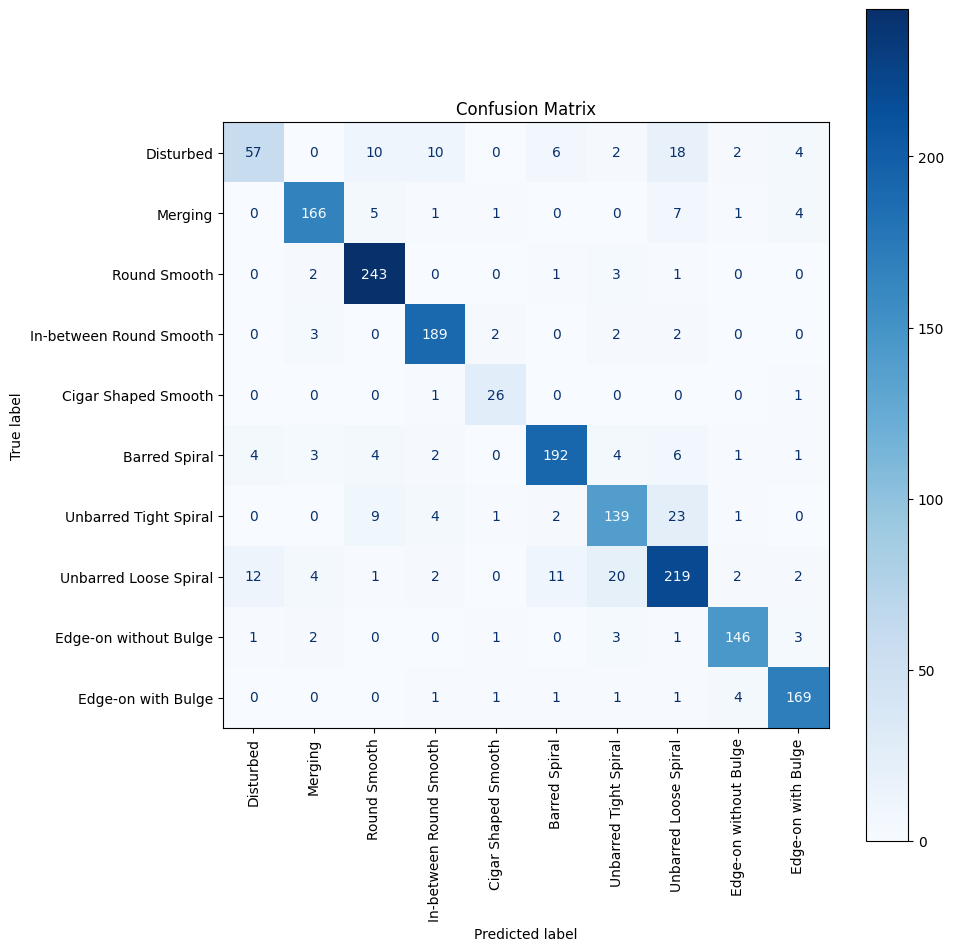

In [ ]:
# Evaluation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained EfficientNet-B3
model.load_state_dict(torch.load("best_mixup.pth", map_location=device))
model.to(device).eval()

test_loader = DataLoader(
    GalaxyDataset(test_ds, val_tf),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Evaluating"):
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().tolist()
        all_preds.extend(preds)
        all_labels.extend(labels.tolist())

metrics = evaluate_predictions(all_preds, all_labels, class_names)

### **EfficientNet-B3 gave us quality >87!**

### Subsequent experiments were with B4, we did not have enough free resources for them, but analyzing the previous training graphs, it would hardly give us a big increase in quality

In [ ]:
# # Training Eff-B4, class-balanced sampler, progressive unfreeze, Cosine LR, AutoAugment, RandAugment, CutMix/MixUp

# wandb.init(project="galaxy10_classification", config={
#     "seed": 42,
#     "model": "efficientnet_b4",
#     "batch_size": 24,
#     "epochs": 50,
#     "img_size": 224,
#     "lr": 3e-4,
#     "weight_decay": 1e-4,
#     "mixup_alpha": 0.4,
#     "cutmix_prob": 0.5,
#     "label_smoothing": 0.1
# })
# cfg = wandb.config
# torch.manual_seed(cfg.seed)
# np.random.seed(cfg.seed)
# random.seed(cfg.seed)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Load and split dataset
# ds = load_dataset("matthieulel/galaxy10_decals")
# split = ds["train"].train_test_split(test_size=0.1, seed=cfg.seed)
# train_ds, val_ds = split["train"], split["test"]
# test_ds = ds["test"]

# # Compute class-balanced sampler for train
# labels = np.array(train_ds["label"])
# class_counts = np.bincount(labels, minlength=10)
# class_weights = 1.0 / class_counts
# sample_weights = class_weights[labels]
# sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

# # Transforms
# mean, std = [0.485,0.456,0.406], [0.229,0.224,0.225]
# train_tf = T.Compose([
#     T.RandomResizedCrop(cfg.img_size, scale=(0.8,1.0)),
#     T.AutoAugment(policy=T.AutoAugmentPolicy.IMAGENET),
#     T.RandAugment(num_ops=2, magnitude=9),
#     T.ColorJitter(0.3,0.3,0.3,0.1),
#     T.RandomHorizontalFlip(),
#     T.RandomVerticalFlip(),
#     T.ToTensor(),
#     T.Normalize(mean, std),
#     T.RandomErasing(p=0.2)
# ])
# val_tf = T.Compose([
#     T.Resize((cfg.img_size, cfg.img_size)),
#     T.ToTensor(),
#     T.Normalize(mean, std),
# ])

# # Dataset wrapper
# class GalaxyDataset(Dataset):
#     def __init__(self, hf_ds, tf): self.ds, self.tf = hf_ds, tf
#     def __len__(self): return len(self.ds)
#     def __getitem__(self, i):
#         img = self.ds[i]["image"]
#         if not isinstance(img, Image.Image): img = Image.fromarray(img)
#         return self.tf(img), self.ds[i]["label"]

# train_loader = DataLoader(
#     GalaxyDataset(train_ds, train_tf),
#     batch_size=cfg.batch_size,
#     sampler=sampler,
#     num_workers=4
# )
# val_loader = DataLoader(
#     GalaxyDataset(val_ds, val_tf),
#     batch_size=cfg.batch_size,
#     shuffle=False,
#     num_workers=2
# )

# # MixUp & CutMix
# def rand_bbox(size, lam):
#     _, _, H, W = size
#     cut_rat = np.sqrt(1.-lam)
#     cw, ch = int(W*cut_rat), int(H*cut_rat)
#     cx, cy = np.random.randint(0,W), np.random.randint(0,H)
#     x1, y1 = max(cx-cw//2,0), max(cy-ch//2,0)
#     x2, y2 = min(cx+cw//2, W), min(cy+ch//2, H)
#     return x1,y1,x2,y2

# def cutmix(x, y, alpha=1.0, prob=0.5):
#     if random.random()>prob or alpha<=0:
#         return x, y, y, 1.0
#     lam = np.random.beta(alpha, alpha)
#     idx = torch.randperm(x.size(0))
#     x1,y1,x2,y2 = rand_bbox(x.size(), lam)
#     x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
#     lam_adj = 1 - ((x2-x1)*(y2-y1)/(x.size(-1)*x.size(-2)))
#     return x, y, y[idx], lam_adj

# def mixup(x, y, alpha=1.0):
#     if alpha<=0:
#         return x, y, y, 1.0
#     lam = np.random.beta(alpha, alpha)
#     idx = torch.randperm(x.size(0))
#     return lam*x + (1-lam)*x[idx], y, y[idx], lam

# # Model, loss, optimizer, scheduler
# model = models.efficientnet_b4(pretrained=True)
# # freeze features for first 3 epochs
# for p in model.features.parameters(): p.requires_grad=False
# nf = model.classifier[1].in_features
# model.classifier = nn.Sequential(nn.Dropout(0.5), nn.Linear(nf, 10))
# model.to(device)

# criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)
# optimizer = optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
# scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs)

# # Training loop with early stopping & unfreeze
# best_val, patience = 0.0, 0
# for epoch in range(1, cfg.epochs+1):
#     model.train()
#     train_corr = 0
#     for x,y in tqdm(train_loader, desc=f"Epoch {epoch}/{cfg.epochs}"):
#         x, y = x.to(device), y.to(device)
#         if random.random()<0.5:
#             x_mix, y_a, y_b, lam = cutmix(x, y, cfg.mixup_alpha, cfg.cutmix_prob)
#         else:
#             x_mix, y_a, y_b, lam = mixup(x, y, cfg.mixup_alpha)
#         optimizer.zero_grad()
#         out = model(x_mix)
#         loss = lam*criterion(out, y_a) + (1-lam)*criterion(out, y_b)
#         loss.backward()
#         optimizer.step()
#         train_corr += (out.argmax(1)==y).sum().item()
#     scheduler.step()

#     # unfreeze after 3 epochs
#     if epoch==3:
#         for p in model.features.parameters(): p.requires_grad=True

#     # validate
#     model.eval()
#     val_corr=0
#     with torch.no_grad():
#         for x,y in val_loader:
#             x,y = x.to(device), y.to(device)
#             val_corr += (model(x).argmax(1)==y).sum().item()

#     train_acc = train_corr/len(train_loader.dataset)
#     val_acc   = val_corr/len(val_loader.dataset)
#     wandb.log({"epoch":epoch,"train_acc":train_acc,"val_acc":val_acc})

#     print(f"Epoch {epoch}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")
#     if val_acc>best_val:
#         best_val, patience = val_acc, 0
#         torch.save(model.state_dict(),"best_wandb.pth")
#         wandb.run.summary["best_val"] = best_val
#     else:
#         patience+=1
#         if patience>=7:
#             print("Early stopping"); break

# wandb.finish()

In [ ]:
# # Evaluation with TTA

# # 1) Init wandb for evaluation
# wandb.init(project="galaxy10_classification", job_type="eval")
# config = wandb.config

# # 2) Constants
# DEVICE     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# BATCH_SIZE = config.batch_size
# IMG_SIZE   = config.img_size
# mean, std  = [0.485,0.456,0.406], [0.229,0.224,0.225]
# class_names = [
#     "Disturbed","Merging","Round Smooth","In-between Round Smooth",
#     "Cigar Shaped Smooth","Barred Spiral","Unbarred Tight Spiral",
#     "Unbarred Loose Spiral","Edge-on without Bulge","Edge-on with Bulge"
# ]

# # 3) Prepare test DataLoader
# class GalaxyTestDataset(torch.utils.data.Dataset):
#     def __init__(self, hf_ds):
#         self.ds = hf_ds
#     def __len__(self):
#         return len(self.ds)
#     def __getitem__(self, idx):
#         ex = self.ds[idx]
#         img = ex["image"]
#         if not isinstance(img, Image.Image):
#             img = Image.fromarray(img)
#         # resize + normalize
#         img = TF.resize(img, (IMG_SIZE, IMG_SIZE))
#         t   = TF.to_tensor(img)
#         t   = TF.normalize(t, mean, std)
#         return t, ex["label"]

# test_ds    = load_dataset("matthieulel/galaxy10_decals")["test"]
# test_loader = DataLoader(
#     GalaxyTestDataset(test_ds),
#     batch_size=BATCH_SIZE,
#     shuffle=False,
#     num_workers=2
# )

# # 4) Load the best model
# model = models.efficientnet_b4(pretrained=False)
# nf    = model.classifier[1].in_features
# model.classifier = nn.Sequential(
#     nn.Dropout(0.5),
#     nn.Linear(nf, len(class_names))
# )
# model.load_state_dict(torch.load("best_wandb.pth", map_location=DEVICE))
# model.to(DEVICE).eval()

# # 5) Define simple TTA: original, horizontal flip, vertical flip
# def tta_predict(batch):
#     batch = batch.to(DEVICE)
#     logits = torch.zeros(batch.size(0), len(class_names), device=DEVICE)
#     for aug in (batch,
#                 torch.flip(batch, [3]),
#                 torch.flip(batch, [2])):
#         logits += model(aug)
#     return (logits / 3).argmax(1).cpu().tolist()

# # 6) Inference loop
# all_preds, all_labels = [], []
# with torch.no_grad():
#     for imgs, labels in tqdm(test_loader, desc="TTA Eval"):
#         preds = tta_predict(imgs)
#         all_preds.extend(preds)
#         all_labels.extend(labels.tolist())

# # 7) Compute and log metrics
# metrics = evaluate_predictions(all_preds, all_labels, class_names)
# wandb.log(metrics)
# print(f"Test Accuracy (with TTA): {metrics['accuracy']*100:.2f}%")

# wandb.finish()
